# This is the script to generate the MNIST32 dataset

In [1]:
# papermill parameters
aid = None
print(f'aid={aid}')

aid=None


In [2]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from tqdm import tqdm
import pickle as pkl

import util

from MNIST32 import MNIST32

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### parameters to re-create the dataset 10 times with 10 different autoencoders

In [30]:
# default: use the model from github
autoencoder_dir = 'disentangling_vae/results/btcvae_mnist/'
Z_DIM = 10

In [8]:
# use one of 10 autoencoder models re-trained with different raandom seeds
if aid is not None:
    autoencoder_dir = [f'./models/btcvae_mnist/btcvae_mnist_{i+1}' for i in range(10)][aid-1]

# load the autoencoder

In [4]:
import sys
sys.path.append(os.path.abspath('./disentangling_vae'))

In [5]:
from disvae.utils.modelIO import load_model, load_metadata

vae_model = load_model(autoencoder_dir)
vae_model.eval()  # don't sample from latent: use mean
vae_model

VAE(
  (encoder): EncoderBurgess(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (mu_logvar_gen): Linear(in_features=256, out_features=30, bias=True)
  )
  (decoder): DecoderBurgess(
    (lin1): Linear(in_features=15, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (lin3): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

## First, train a simplenet as the labelling function on the autoeoncoded dataset

## pass the mnist dataset through the autoencoder

In [6]:
transform = transforms.Compose([transforms.Resize((32, 32)), 
                                transforms.ToTensor(),])

### load mnist

In [7]:
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=64, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=64, shuffle=False
)

In [8]:
# train
vae_model.eval()
mnist_train_encoded = []
with torch.no_grad():
    for x, label in tqdm(DataLoader(trainset)):
        x = x.to(device)
        mu, logvar = vae_model.encode(x)
        z = vae_model.reparameterize(mu, logvar)
        rec = vae_model.decode(z)        
        mnist_train_encoded.append((x.detach().cpu().numpy(), 
                                    label, 
                                    rec.detach().cpu().numpy(), 
                                    mu.detach().cpu().numpy(), 
                                    logvar.detach().cpu().numpy(), 
                                    z.detach().cpu().numpy()))

100%|██████████| 60000/60000 [01:02<00:00, 959.63it/s]


In [9]:
# test
mnist_test_encoded = []
with torch.no_grad():
    for x, label in tqdm(DataLoader(testset)):
        x = x.to(device)
        mu, logvar = vae_model.encode(x)
        z = vae_model.reparameterize(mu, logvar)
        rec = vae_model.decode(z)
        mnist_test_encoded.append((x.detach().cpu().numpy(), 
                                   label, 
                                   rec.detach().cpu().numpy(), 
                                   mu.detach().cpu().numpy(), 
                                   logvar.detach().cpu().numpy(), 
                                   z.detach().cpu().numpy()))

100%|██████████| 10000/10000 [00:10<00:00, 972.84it/s]


## Train a SimplenetV1 on the reconstructed images - this is the labelling function

In [ ]:
# some mnist benchmark with code: https://github.com/kk7nc/RMDL

In [10]:
enc_train = util.list_to_dataset([(z, torch.tensor(rec), c) for _, c, rec, _, _, z in mnist_train_encoded ])
enc_trainloder = trainloader = DataLoader(enc_train, batch_size=64, shuffle=True)

enc_test = util.list_to_dataset([(z, torch.tensor(rec), c) for _, c, rec, _, _, z in mnist_test_encoded ])
enc_testloder = trainloader = DataLoader(enc_test, batch_size=64, shuffle=True)

In [11]:
from Simplenet import SimplenetV1
def simplenet_model_and_optimizer():
    model = SimplenetV1()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return model, optimizer
model, optimizer = simplenet_model_and_optimizer()

In [12]:
from torch.optim.lr_scheduler import StepLR

#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
for i in range(5):    
    # gradient descent on the dataset
    train_zero_one_loss, _ = util.train(model, optimizer, enc_trainloder, enc_testloder, device, n_epoch=1)
    #scheduler.step()

100%|██████████| 938/938 [00:24<00:00, 38.65it/s]


Train Error:  0.0432


  0%|          | 4/938 [00:00<00:24, 37.83it/s]

Test Error:  0.0325


100%|██████████| 938/938 [00:24<00:00, 38.55it/s]


Train Error:  0.0295


  0%|          | 4/938 [00:00<00:24, 37.81it/s]

Test Error:  0.0328


100%|██████████| 938/938 [00:24<00:00, 38.70it/s]


Train Error:  0.029383333333333334


  0%|          | 4/938 [00:00<00:25, 36.33it/s]

Test Error:  0.0344


100%|██████████| 938/938 [00:24<00:00, 38.49it/s]


Train Error:  0.027933333333333334


  0%|          | 4/938 [00:00<00:25, 37.31it/s]

Test Error:  0.0337


100%|██████████| 938/938 [00:24<00:00, 38.43it/s]


Train Error:  0.0275
Test Error:  0.0321


In [35]:
simplenetfile = './models/mnist_label_simplenet.pth'

In [ ]:
if aid is not None:
    simplenetfile = f'./models/mnist_label_simplenet_{aid}.pth'

In [14]:
torch.save(model.state_dict(), simplenetfile)

## performance for synthetic images

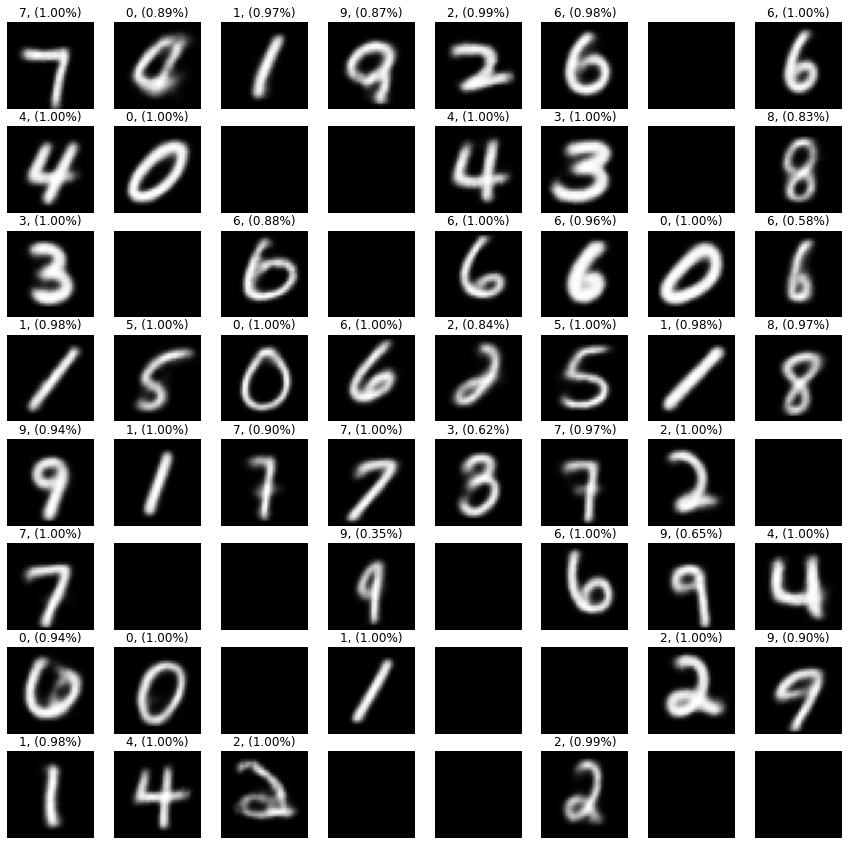

In [15]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

model.eval()
prior_samples = torch.randn(64, Z_DIM)
sample = vae_model.decode(prior_samples.cuda())
predictions = model(sample).softmax(axis=1)

fig, ax = plt.subplots(8, 8, figsize=(15,15))
for i in range(8):
    for j in range(8):
        idx = 8*i+j
        if np.random.random() < predictions.max(axis=1)[0][idx]**2:
            ax[i, j].imshow(sample[idx].detach().cpu()[0], cmap='gray')
            ax[i, j].axis('off')
            ax[i, j].set_title(f'{predictions.argmax(axis=1)[idx]}, ({predictions.max(axis=1)[0][idx]:.2f}%)')
        else:
            ax[i, j].imshow(np.zeros((32,32)), cmap='gray')
            ax[i, j].axis('off')
plt.show()

In [16]:
def sample_datapoint():
    model.eval()
    p_reject = 1
    while np.random.random() < p_reject:
        prior_sample = torch.randn(1, Z_DIM)
        sample = vae_model.decode(prior_sample.cuda())
        prediction = model(sample).softmax(axis=1)
        p_reject = 1 - prediction.max()**2
    return prior_sample.flatten(), sample.detach().cpu().squeeze(), prediction.argmax().item()

In [17]:
z, x, c = sample_datapoint()

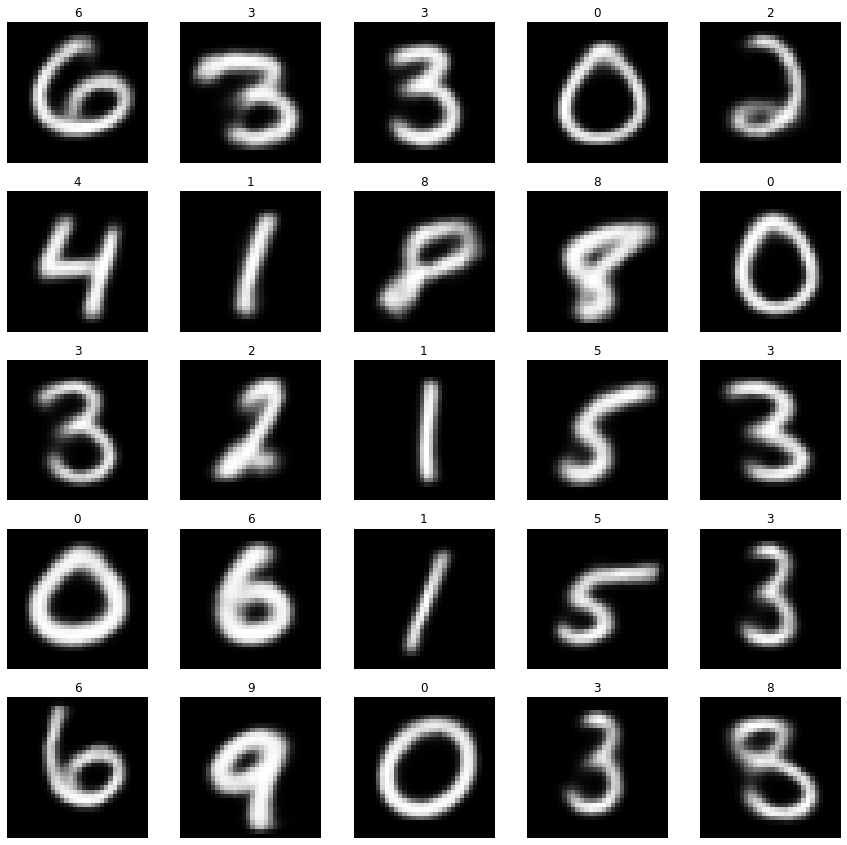

In [18]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))
for i in range(5):
    for j in range(5):
        idx = 5*i+j
        _, x, c = sample_datapoint()
        ax[i, j].imshow(x, cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title(f'{c}')
plt.show()

In [19]:
dataset = [sample_datapoint() for _ in tqdm(range(5000))]

100%|██████████| 5000/5000 [00:15<00:00, 316.87it/s]


In [20]:
# class balance
for c in range(10):
    print(f'class {c}: {np.mean(np.array([c1 for _, _, c1 in dataset]) == c):.3f}')

class 0: 0.112
class 1: 0.104
class 2: 0.102
class 3: 0.110
class 4: 0.085
class 5: 0.096
class 6: 0.091
class 7: 0.120
class 8: 0.113
class 9: 0.067


# Equipped with the labelling function, draw the training and validation data

### With pytorch and numpy random seeds for reproducibility

In [21]:
import util
from util import compute_tangent_space, project_into_tangent_space, normalize_image, dcn

In [22]:
torch.manual_seed(0)
np.random.seed(0)

mnist = MNIST32(modelfile = autoencoder_dir, 
                simplenetfile = simplenetfile,
                Z_DIM=Z_DIM)
z, x, c = mnist.sample()

print(z, x[0], c)

tensor([ 0.8487,  0.4802,  1.4992,  0.3528, -0.1136,  1.3628,  0.0718, -1.0646,
        -1.9801, -0.6151, -1.0690,  0.9896,  1.0753,  0.0426,  0.0811]) tensor([7.4168e-05, 1.4409e-07, 9.9867e-09, 2.3955e-08, 3.8387e-08, 9.0241e-08,
        2.4386e-07, 3.9133e-06, 1.1236e-05, 5.4157e-05, 1.3932e-04, 1.0066e-03,
        1.4043e-03, 1.3039e-03, 1.8030e-03, 4.4700e-03, 3.4923e-03, 1.2679e-03,
        5.5913e-04, 5.7229e-04, 6.4274e-04, 3.2661e-04, 1.2962e-04, 1.0014e-04,
        1.7199e-05, 1.0770e-05, 2.5877e-05, 6.9620e-05, 3.8090e-05, 3.3852e-05,
        2.0527e-05, 1.1154e-05]) 6


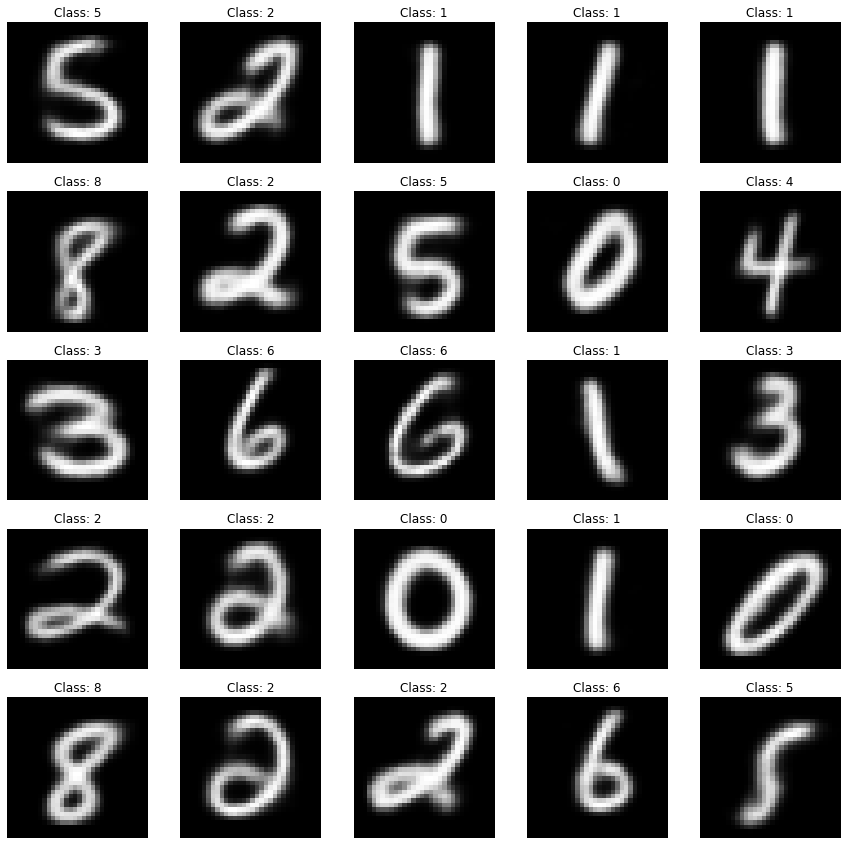

In [23]:
# visualize random samples from the dataset
z_batch, x_batch, c_batch = util.sample_batch(mnist, 25)
fix, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        img = x_batch[5*i+j, :, :, :]
        c = c_batch[5*i+j]
        axs[i,j].imshow(dcn(img.squeeze()), cmap='gray', interpolation='none')
        axs[i,j].set_title(f'Class: {c}')
        axs[i,j].axis('off')
plt.show()

### draw the training dataset

In [45]:
trainfile = './data/MNIST32_train.pkl'

In [46]:
if aid is not None:
    trainfile = f'./data/MNIST32_train_{aid}.pkl'

In [25]:
torch.manual_seed(0 if aid is None else aid) # for reproducibility. in the replications, the seed depends on the replication 
np.random.seed(0 if aid is None else aid)

MNIST32_X = torch.zeros((60000, 1, 32, 32))
MNIST32_Y = torch.zeros((60000), dtype=torch.long)
MNIST32_Z = torch.zeros((60000, Z_DIM))

toPIL = transforms.ToPILImage()
for i in tqdm(range(60000)):
    z_s, x_s, c_s = util.sample_batch(mnist, 1)
    MNIST32_X[i, 0, : , :] = x_s
    MNIST32_Y[i] = c_s
    MNIST32_Z[i] = z_s
    
torch.save((MNIST32_X, MNIST32_Y, MNIST32_Z), trainfile)

100%|██████████| 60000/60000 [03:23<00:00, 294.71it/s]


### draw the validation dataset

In [51]:
valfile = './data/MNIST32_val.pkl'

In [49]:
if aid is not None:
    valfile = f'./data/MNIST32_val_{aid}.pkl'

In [27]:
# for reproducibility, assume that this cell is being executed directly after drawing the training dataset
MNIST32_X = torch.zeros((10000, 1, 32, 32))
MNIST32_Y = torch.zeros((10000), dtype=torch.long)
MNIST32_Z = torch.zeros((10000, Z_DIM))

toPIL = transforms.ToPILImage()
for i in tqdm(range(10000)):
    z_s, x_s, c_s = util.sample_batch(mnist, 1)
    MNIST32_X[i, 0, : , :] = x_s
    MNIST32_Y[i] = c_s
    MNIST32_Z[i] = z_s
    
torch.save((MNIST32_X, MNIST32_Y, MNIST32_Z), valfile)

100%|██████████| 10000/10000 [00:33<00:00, 294.68it/s]
